In [2]:
%matplotlib inline
import cv2
import keras.backend as K
import matplotlib.pyplot as plt
import numpy as np
from keras.layers import GlobalAveragePooling2D, multiply, LeakyReLU, Permute
from keras.layers import Input, Dense, Reshape, Dropout, Concatenate
from keras.layers.convolutional import UpSampling2D, Conv2D
from keras.models import Model
from keras_contrib.layers.normalization.instancenormalization import InstanceNormalization
from skimage import transform as trans
from retinaface import RetinaFace

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"  # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

### Load detection and align model

In [4]:
image_size = [256, 256]

src = np.array([
    [30.2946, 51.6963],
    [65.5318, 51.5014],
    [48.0252, 71.7366],
    [33.5493, 92.3655],
    [62.7299, 92.2041]], dtype=np.float32)

src[:, 0] += 8.0
src[:, 0] += 15.0
src[:, 1] += 30.0
src /= 112
src *= 200

In [5]:
def list2array(values):
    return np.array(list(values))


def align_face(img):
    faces = RetinaFace.detect_faces(img)
    bounding_boxes = np.array([list2array(faces[face]['facial_area']) for face in faces])
    points = np.array([list2array(faces[face]['landmarks'].values()) for face in faces])
    white_image = np.ones(img.shape, dtype=np.uint8) * 255

    result_faces = []
    result_masks = []
    result_matrix = []

    if bounding_boxes.shape[0] > 0:
        det = bounding_boxes[:, 0:4]
        for i in range(det.shape[0]):
            _det = det[i]
            dst = points[i]

            tform = trans.SimilarityTransform()
            tform.estimate(dst, src)
            M = tform.params[0:2, :]
            warped = cv2.warpAffine(img, M, (image_size[1], image_size[0]), borderValue=0.0)
            mask = cv2.warpAffine(white_image, M, (image_size[1], image_size[0]), borderValue=0.0)

            result_faces.append(warped)
            result_masks.append(mask)
            result_matrix.append(tform.params[0:3, :])

    return result_faces, result_masks, result_matrix


In [6]:
def put_face_back(img, faces, masks, result_matrix):
    for i in range(len(faces)):
        M = np.linalg.inv(result_matrix[i])[0:2]
        warped = cv2.warpAffine(faces[i], M, (img.shape[1], img.shape[0]), borderValue=0.0)
        mask = cv2.warpAffine(masks[i], M, (img.shape[1], img.shape[0]), borderValue=0.0)
        mask = mask // 255
        img = img * (1 - mask)
        img = img.astype(np.uint8)
        img += warped * mask
    return img

### Load GAN

In [7]:
def squeeze_excite_block(input, ratio=4):
    """ Create a channel-wise squeeze-excite block
    Args:
        input: input tensor
        filters: number of output filters
    Returns: a keras tensor
    References
    -   [Squeeze and Excitation Networks](https://arxiv.org/abs/1709.01507)
    :param input:
    :param ratio:
    """
    init = input
    channel_axis = 1 if K.image_data_format() == "channels_first" else -1
    filters = init.shape[channel_axis]
    se_shape = (1, 1, filters)

    se = GlobalAveragePooling2D()(init)
    se = Reshape(se_shape)(se)
    se = Dense(filters // ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)

    if K.image_data_format() == 'channels_first':
        se = Permute((3, 1, 2))(se)

    x = multiply([init, se])
    return x


def conv2d(layer_input, filters, f_size=4, bn=True, se=False):
    """Layers used during down sampling"""
    d = Conv2D(filters, kernel_size=f_size, strides=2, padding='same')(layer_input)
    d = LeakyReLU(alpha=0.2)(d)
    if bn:
        d = InstanceNormalization()(d)
    if se:
        d = squeeze_excite_block(d)
    return d


def deconv2d(layer_input, skip_input, filters, f_size=4, dropout_rate=0):
    """Layers used during up sampling"""
    u = UpSampling2D(size=2)(layer_input)
    u = Conv2D(filters, kernel_size=f_size, strides=1, padding='same', activation='relu')(u)
    if dropout_rate:
        u = Dropout(dropout_rate)(u)
    u = InstanceNormalization()(u)
    u = Concatenate()([u, skip_input])
    return u


def atrous(layer_input, filters, f_size=4, bn=True):
    a_list = []
    for rate in [2, 4, 8]:
        a = Conv2D(filters, f_size, dilation_rate=rate, padding='same')(layer_input)
        a_list.append(a)
    a = Concatenate()(a_list)
    a = LeakyReLU(alpha=0.2)(a)
    if bn:
        a = InstanceNormalization()(a)
    return a


K.set_learning_phase(0)

# Image input
d0 = Input(shape=(256, 256, 3))

gf = 64
# Downsampling
d1 = conv2d(d0, gf, bn=False, se=True)
d2 = conv2d(d1, gf * 2, se=True)
d3 = conv2d(d2, gf * 4, se=True)
d4 = conv2d(d3, gf * 8)
d5 = conv2d(d4, gf * 8)

a1 = atrous(d5, gf * 8)

# Upsampling
u3 = deconv2d(a1, d4, gf * 8)
u4 = deconv2d(u3, d3, gf * 4)
u5 = deconv2d(u4, d2, gf * 2)
u6 = deconv2d(u5, d1, gf)

u7 = UpSampling2D(size=2)(u6)

output_img = Conv2D(3, kernel_size=4, strides=1, padding='same', activation='tanh')(u7)

model = Model(d0, output_img)

In [8]:
model.load_weights('./saved_model/faces_bald_InsNorm_4x4_D2/model_G_5_170.hdf5')

### Test on image

In [9]:
def proc_files(filelist):
    for filename in filelist:
        img = cv2.imread(filename)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        faces, masks, matrix = align_face(img)
        result_faces = []

        for face in faces:
            input_face = np.expand_dims(face, axis=0)
            input_face = input_face / 127.5 - 1.
            result = model.predict(input_face)[0]
            result = ((result + 1.) * 127.5)
            result = result.astype(np.uint8)
            result_faces.append(result)

        img_result = put_face_back(img, result_faces, masks, matrix)
        img_result = np.hstack([img, img_result])

        plt.figure(figsize=(9, 9))
        plt.axis('off')
        plt.imshow(img_result)
        plt.show()
    

1/1 [==============================] - 1s 503ms/step


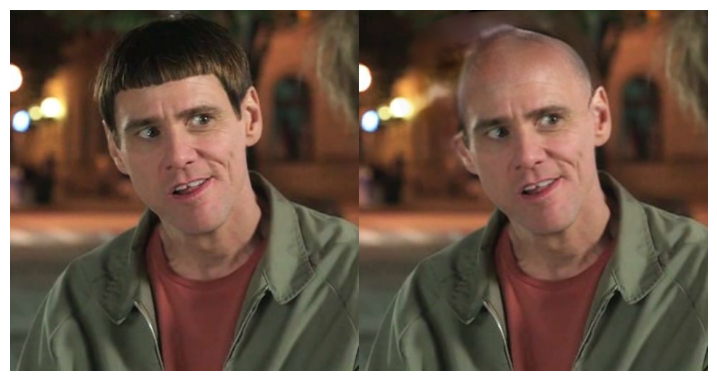

In [10]:
proc_files(['./examples/12.jpg'])